# Code

This notebook import and plot Near-Field (NF) measured data from XY planes acquired with a Vector Network Analyzer (VNA) using an out-of-date robotic arm. The functions defined here are:
- importPlane: import a single file from a folder, ignoring the head (skipRows=33). Input: complete path of the data file. Output: plane DataFrame;
- importInfoPlane: import a single file to extract informations about the scanning edges, distance between probe and AUT, and steps of each axis. Input: complete path of the data file. Output: a dictionary entry;
- importMultPlanes: import multiple files in a folder using importPlane and importInfoPlane. Input: path containing all data file. Output: a dictionary of DataFrames where the last entry is the information imported with importInfoPlane;
- calcMag: calculate the magnitude and phase of a sigle DataFrame. The normalized magnitude is calculated based on the higher value of the magnitude of the imported plane. Requires execution of importPlane first. Input: imported plane. Output: add the magnitude (Mag), the normalized magnitude (Mag Norm), and the phase (Phase) at the end of the DataFrame columns;
- calcMagMultPlanes: calculate the magnitude, phase, and normalized magnitude using calcMag. It also calculate a normalized magnitude considering all planes. Requires execution of importMultPlanes first. Input: dictionary of planes and the column of the desired frequency. Output: add Mag, Mag Norm, and Phase at the end of each DataFrame. It also calculate the normalized magnitude considering all planes (Mag Norm Planes). Returns the maximum and minumum values of the normalized magnitude of all planes;
- plotMultPlanes: plot all planes imported with importMultPlanes. Requires execution of calcMagMultPlanes first. Input: dictionary of planes and the column of the desired frequency. Output: a list of bidimensional colormap plots;
- plotSinglePlane: used to export a single plotted plane as PNG. Requires execution of calcMagMultPlanes first. Performs an interpolation of the center vertical and horizontal lines to provide an approximation of the beamwaist dimension. Input: dictionary of planes, the desired plane, and the column of the desired frequency. Output: single plane plot with the size information of the beamwaist;
- cutPlane: plot the vertical (transverse) or the horizontal (longitudinal) cuts of the normalized magnitude of all planes. Requires execution of calcMagMultPlanes or plotMultPlanes first. Input: dictionary of planes and the orientation (vertical or horizontal). Output: single plane bidimensional colormap plot;
- plotPlane: plot the measured transverse (vertical) or longitudinal (horizontal) section. This file is a XZ or YZ measurement to compare with the cutPlane plots. Input: complete path of the data file. Output: single plane bidimensional colormap plot.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import os

In [2]:
def importPlane(pathFile, skipRows=33):
    plane = pd.read_csv(pathFile,
                        sep = ':|,',
                        skiprows = skipRows,
                        encoding = 'Latin',
                        engine = 'python')
    plane.columns = [item.strip() for item in plane]
    return plane

In [3]:
def importInfoPlane(pathFile):
    with open(pathFile) as f:
        text = f.read()
        info = {'x axis' : float(re.findall(r'(?<=Distance \(mm\) \(x\)\:\s).*?(?=\t)', text)[0]),
                          'y axis' : float(re.findall(r'(?<=Distance \(mm\) \(y\)\:\s).*?(?=\t)', text)[0]),
                          'z axis' : float(re.findall(r'(?<=Distance \(mm\) \(z\)\:\s).*', text)[0]),
                          'z ini' : float(re.findall(r'(?<=Robot \(mm\)\:\s).*', text)[0]),
                          'points' : float(re.findall(r'(?<=Points \(x\)\:\s).*?(?=\t)', text)[0]),
                          'lines' : float(re.findall(r'(?<=Points \(y\)\:\s).*?(?=\t)', text)[0]),
                          'planes' : float(re.findall(r'(?<=Points \(z\)\:\s).*', text)[0])}
    return info

In [4]:
def importMultPlanes(path, skipRows=33):
    planesFiles = [os.path.join(path, f) for f in os.listdir(path) if f.endswith('.txt')]
    planes = {}
    
    for i, plane in enumerate(planesFiles):
        planes['Plane {}'.format(i)] = importPlane(plane)
    
    planes['Info'] = importInfoPlane(planesFiles[0])
    
    print('{} planes were imported. There are {} columns in the first plane:\n{}'.format(
        len(planesFiles), len(planes['Plane 0'].keys()), planes['Plane 0'].keys()))
    return planes

In [5]:
def calcMag(plane, column=4):
    try:
        float(plane.iloc[:,column].name)
    except:
        print('The selected column is not the real component of the complex number.')

    plane['Mag'] = 20 * np.log10(np.sqrt(plane.iloc[:,column] ** 2 + plane.iloc[:,column+1] ** 2))
    plane['Mag Norm'] = plane['Mag'] - np.max(plane['Mag'])
    plane['Phase'] = np.rad2deg(np.arctan2(plane.iloc[:,column+1], plane.iloc[:,column]))

In [6]:
def calcMagMultPlanes(dictPlanes, column=4):
    multPlaneMax = -60
    multPlaneMin = 10

    # Finding maximum Mag value
    for plane in list(dictPlanes)[:-1]:
        calcMag(dictPlanes[plane], column=column)
        if dictPlanes[plane]['Mag'].max() > multPlaneMax:
            multPlaneMax = dictPlanes[plane]['Mag'].max()
    
    # Subtracting the maximum Mag value at every plane (Mag Norm Planes)
    for plane in list(dictPlanes)[:-1]:
        dictPlanes[plane]['Mag Norm Planes'] = dictPlanes[plane]['Mag'] - multPlaneMax # This ensures that the maximum value will be 0
        if dictPlanes[plane]['Mag Norm Planes'].min() < multPlaneMin:
            multPlaneMin = dictPlanes[plane]['Mag Norm Planes'].min()

    dictPlanes['Info']['freq'] = float(dictPlanes['Plane 0'].iloc[:,column].name)/1e9
    
    return multPlaneMax==0, multPlaneMin

In [7]:
def plotMultPlanes(dictPlanes, interpolationMethod='hanning', contourLevels=[-10, -3], column=4, mag_phase='Mag Norm Planes', saveFig='no'):
    lines = int(np.ceil(len(dictPlanes)/3))
    plt.figure(figsize=(15,lines*5))
    
    x = dictPlanes['Info']['x axis'] / 2
    y = dictPlanes['Info']['y axis'] / 2
    ext=(-x, x, -y, y)
    
    planesMax, planesMin = calcMagMultPlanes(dictPlanes=dictPlanes, column=column)
    
    for i, df in enumerate(list(dictPlanes)[:-1]):
        pivPlan = dictPlanes[df].pivot_table(columns='X', index='Y', values=mag_phase)
        plt.subplot(lines, 3, i+1)
        plt.imshow(pivPlan, interpolation=interpolationMethod, cmap='turbo', extent=ext, vmin=planesMin, vmax=planesMax)
        plt.colorbar(shrink=0.85)
        plt.contour(pivPlan, levels=contourLevels, extent=ext)
        plt.xticks(np.linspace(-x, x, 11), rotation=35)
        plt.yticks(np.linspace(-y, y, 11))
        plt.title(df)

    if saveFig=='yes':
        plt.savefig('Mult planes - {} GHz.png'.format(float(dictPlanes['Plane 0'].iloc[:,column].name)/1e9), dpi=200, bbox_inches="tight")
    else:
        pass

In [8]:
def plotSinglePlane(dictPlanes, plane, interpolationMethod='hanning', beamwaistLevel = -3,
                   contourLevels=[-10, -3], column=4, mag_phase='Mag Norm Planes', saveFig='no'):
    #lines = int(np.ceil(len(dictPlanes)/3))
    plt.figure(figsize=(12,4))
    
    x = dictPlanes['Info']['x axis'] / 2
    y = dictPlanes['Info']['y axis'] / 2
    ext=(-x, x, -y, y)
    
    planesMax, planesMin = calcMagMultPlanes(dictPlanes=dictPlanes, column=column)
    
    pivPlan = dictPlanes[plane].pivot_table(columns='X', index='Y', values=mag_phase)

    plt.imshow(pivPlan, interpolation=interpolationMethod, cmap='turbo', extent=ext, vmin=planesMin, vmax=planesMax)
    plt.colorbar(pad=0.015)
    plt.contour(pivPlan, levels=contourLevels, extent=ext)
    plt.xticks(np.linspace(-x, x, 11), rotation=35)
    plt.yticks(np.linspace(-y, y, 11))
    plt.title(plane)

    if saveFig=='yes':
        plt.savefig('{} - {} GHz.png'.format(plane, dictPlanes['Info']['freq']), dpi=200, bbox_inches="tight")
    else:
        pass
    
    middle = int(len(pivPlan)/2)
    interxp = np.linspace(-150, 150, 1000)
    interfp = np.interp(interxp, pivPlan.iloc[:,middle].index, pivPlan.iloc[:,middle].values)
    dfTemp = pd.DataFrame({'x':interxp, 'y': interfp})
    try:
        ePlane = np.abs(dfTemp[dfTemp['y']>beamwaistLevel].iloc[(0,0)]) + np.abs(dfTemp[dfTemp['y']>beamwaistLevel].iloc[(-1,0)])
    except IndexError:
        ePlane = 0

    
    interfp = np.interp(interxp, pivPlan.iloc[middle,:].index, pivPlan.iloc[middle,:].values)
    dfTemp = pd.DataFrame({'x':interxp, 'y': interfp})
    try:
        hPlane = np.abs(dfTemp[dfTemp['y']>beamwaistLevel].iloc[(0,0)]) + np.abs(dfTemp[dfTemp['y']>beamwaistLevel].iloc[(-1,0)])
    except:
        hPlane = 0

    print('E-plane beamwaist ({} dB): {:.2f} mm \nH-plane beamwaist ({} dB): {:.2f} mm'.format(beamwaistLevel, ePlane, beamwaistLevel, hPlane))

In [9]:
def cutPlane(dictPlanes, orientation='vertical', interpolationMethod='hanning', contourLevels=[-10, -3], 
             cut=0, mag_phase='Mag Norm Planes', saveFig='no'):    
    if orientation == 'vertical':
        col = 'X'
        col2 = 'Y'
        axis = 'y axis'
        pl = 'lines'
    elif orientation == 'horizontal':
        col = 'Y'
        col2 = 'X'
        axis = 'x axis'
        pl = 'points'
    else:
        return print('Choose a valid orientation.')

    if dictPlanes['Plane 0'][dictPlanes['Plane 0'][col]==cut][col2].empty:
        return print('Error: choose one of the following values to cut:\n{}'.format(dictPlanes['Plane 0'][col].unique()))
    
    i=0
    dfTemp = pd.DataFrame()

    for key, df in list(dictPlanes.items())[:-1]:
        colSel = df[df[col]==cut][[col2, mag_phase]]
        colSel['z'] = i
        dfTemp = pd.concat([dfTemp, colSel], axis=0)
        i+=1

    yAxis = dictPlanes['Info'][axis] / 2
    xAxisIni = dictPlanes['Info']['z ini']
    xAxisEnd = xAxisIni + dictPlanes['Info']['z axis']
    ext = (xAxisIni, xAxisEnd, -yAxis, yAxis)
    
    print('{} cut in {} mm.'.format(orientation, cut).capitalize())
    dfTemp.reset_index(drop=True, inplace=True)
    pivTemp = dfTemp.pivot_table(index=dfTemp.iloc[:,0].name, columns=dfTemp.iloc[:,2].name, values=mag_phase)
    plt.imshow(pivTemp, interpolation=interpolationMethod, cmap='turbo', vmin=min(pivTemp.min()), vmax=max(pivTemp.max()), extent=ext, aspect='equal')
    plt.colorbar(pad=0.015).set_ticks(np.linspace(min(pivTemp.min()), max(pivTemp.max()), 10))
    plt.contour(pivTemp, levels=contourLevels, extent=ext)
    plt.xticks(np.linspace(xAxisIni, xAxisEnd, 11), rotation=35)
    plt.yticks(np.linspace(-yAxis, yAxis, 11))
    plt.title('{} cut'.format(orientation).capitalize())

    if saveFig=='yes':
        filename = '{} cut at {} mm - {} GHz.png'.format(orientation, cut, dictPlanes['Info']['freq'])
        plt.savefig(filename[0].capitalize()+filename[1:], dpi=200, bbox_inches="tight")
    else:
        pass

In [10]:
def plotPlane(planeFile, propagation='transverse', interpolationMethod='hanning', 
              contourLevel=[-10, -3], column=4, mag_phase='Mag Norm', saveFig='no'):
    if propagation=='transverse':
        idx = 'Y'
        axisV = 'y axis'
        pl = 'lines'
    elif propagation=='longitudinal':
        idx = 'X'
        axisV = 'x axis'
        pl = 'points'
    else:
        return print('Choose a valid orientation')
    # print(planeFile)
    plane = importPlane(planeFile)
    # print(plane)
    info = importInfoPlane(planeFile)
    calcMag(plane=plane, column=column)
    
    z_end = info['z ini'] + info['z axis']
    y = info[axisV] / 2
    ext=(info['z ini'], z_end, -y, y)

    pivPlan = plane.pivot_table(columns='Z', index=idx, values=mag_phase)

    try:
        plt.contour(pivPlan, levels=contourLevel, extent=ext)
    except TypeError:
        return print("Choose the correct orientation.")
        
    plt.imshow(pivPlan, interpolation=interpolationMethod, cmap='turbo', extent=ext)
    plt.colorbar(pad=0.015).set_ticks(np.linspace(min(pivPlan.min()), max(pivPlan.max()), 10))
    plt.contour(pivPlan, levels=contourLevel, extent=ext)
    plt.xticks(np.linspace(info['z ini'], z_end, 11), rotation=35)
    plt.yticks(np.linspace(-y, y, 11))
    plt.title('{} cut'.format(propagation).capitalize())

    if saveFig=='yes':
        plt.savefig('Measured {} plane - {} GHz.png'.format(propagation, float(plane.iloc[:,column].name)/1e9),
                    dpi=200, bbox_inches="tight")
    else:
        pass

# X-band

In [11]:
# Creates a dictionary of all planes in the folder. Be careful with the file order.
# The files are organized in columns, where 'Frequency' is the N-th point, 'X', 'Y', and 'Z' are the position in mm, and
# the rest of the columns are named after the measured frequency in hertz. For example, the column '8200000000.0' is the 
# real part of the S-parameter measured at 8.2 GHz, while the '8200000000.0.1' is the imaginary part.

planesX = importMultPlanes('./Data/X-band/Planes/')

20 planes were imported. There are 66 columns in the first plane:
Index(['Frequency', 'X', 'Y', 'Z', '8200000000.0', '8200000000.0.1',
       '8340000000.0', '8340000000.0.1', '8480000000.0', '8480000000.0.1',
       '8620000000.0', '8620000000.0.1', '8760000000.0', '8760000000.0.1',
       '8900000000.0', '8900000000.0.1', '9040000000.0', '9040000000.0.1',
       '9180000000.0', '9180000000.0.1', '9320000000.0', '9320000000.0.1',
       '9460000000.0', '9460000000.0.1', '9600000000.0', '9600000000.0.1',
       '9740000000.0', '9740000000.0.1', '9880000000.0', '9880000000.0.1',
       '10020000000.0', '10020000000.0.1', '10160000000.0', '10160000000.0.1',
       '10300000000.0', '10300000000.0.1', '10440000000.0', '10440000000.0.1',
       '10580000000.0', '10580000000.0.1', '10720000000.0', '10720000000.0.1',
       '10860000000.0', '10860000000.0.1', '11000000000.0', '11000000000.0.1',
       '11140000000.0', '11140000000.0.1', '11280000000.0', '11280000000.0.1',
       '11420000000.

In [12]:
df = pd.DataFrame()
df['Freq'] = planesX['Plane 0'].columns[4::2]#.astype(float)
df.set_index('Freq', inplace=True)
for plane in list(planesX)[:-1]:
    re = planesX[plane][(planesX[plane]['X'] == 0) & (planesX[plane]['Y'] == 0)].loc[:,df.index]
    im = planesX[plane][(planesX[plane]['X'] == 0) & (planesX[plane]['Y'] == 0)].loc[:,df.index+'.1']
    df[plane] = 20 * np.log10(np.sqrt(re.values[0]**2 + im.values[0]**2))

In [13]:
# Verification of first, middle, and last frequencies in the X-band measurement with 31 number of points of frequencies.
# The corresponding columns in the DataFrame are 4, 34, and 64.
# Since all measurements were performed with 31 frequency points, these values will be the same for other frequency ranges

a = np.linspace(8.2, 12.4, 31)
print(a[0], a[int((len(a)-1)/2)], a[len(a)-1])
print(planesX['Plane 0'].iloc[:,4].name, planesX['Plane 0'].iloc[:,34].name, planesX['Plane 0'].iloc[:,64].name)

8.2 10.3 12.4
8200000000.0 10300000000.0 12400000000.0


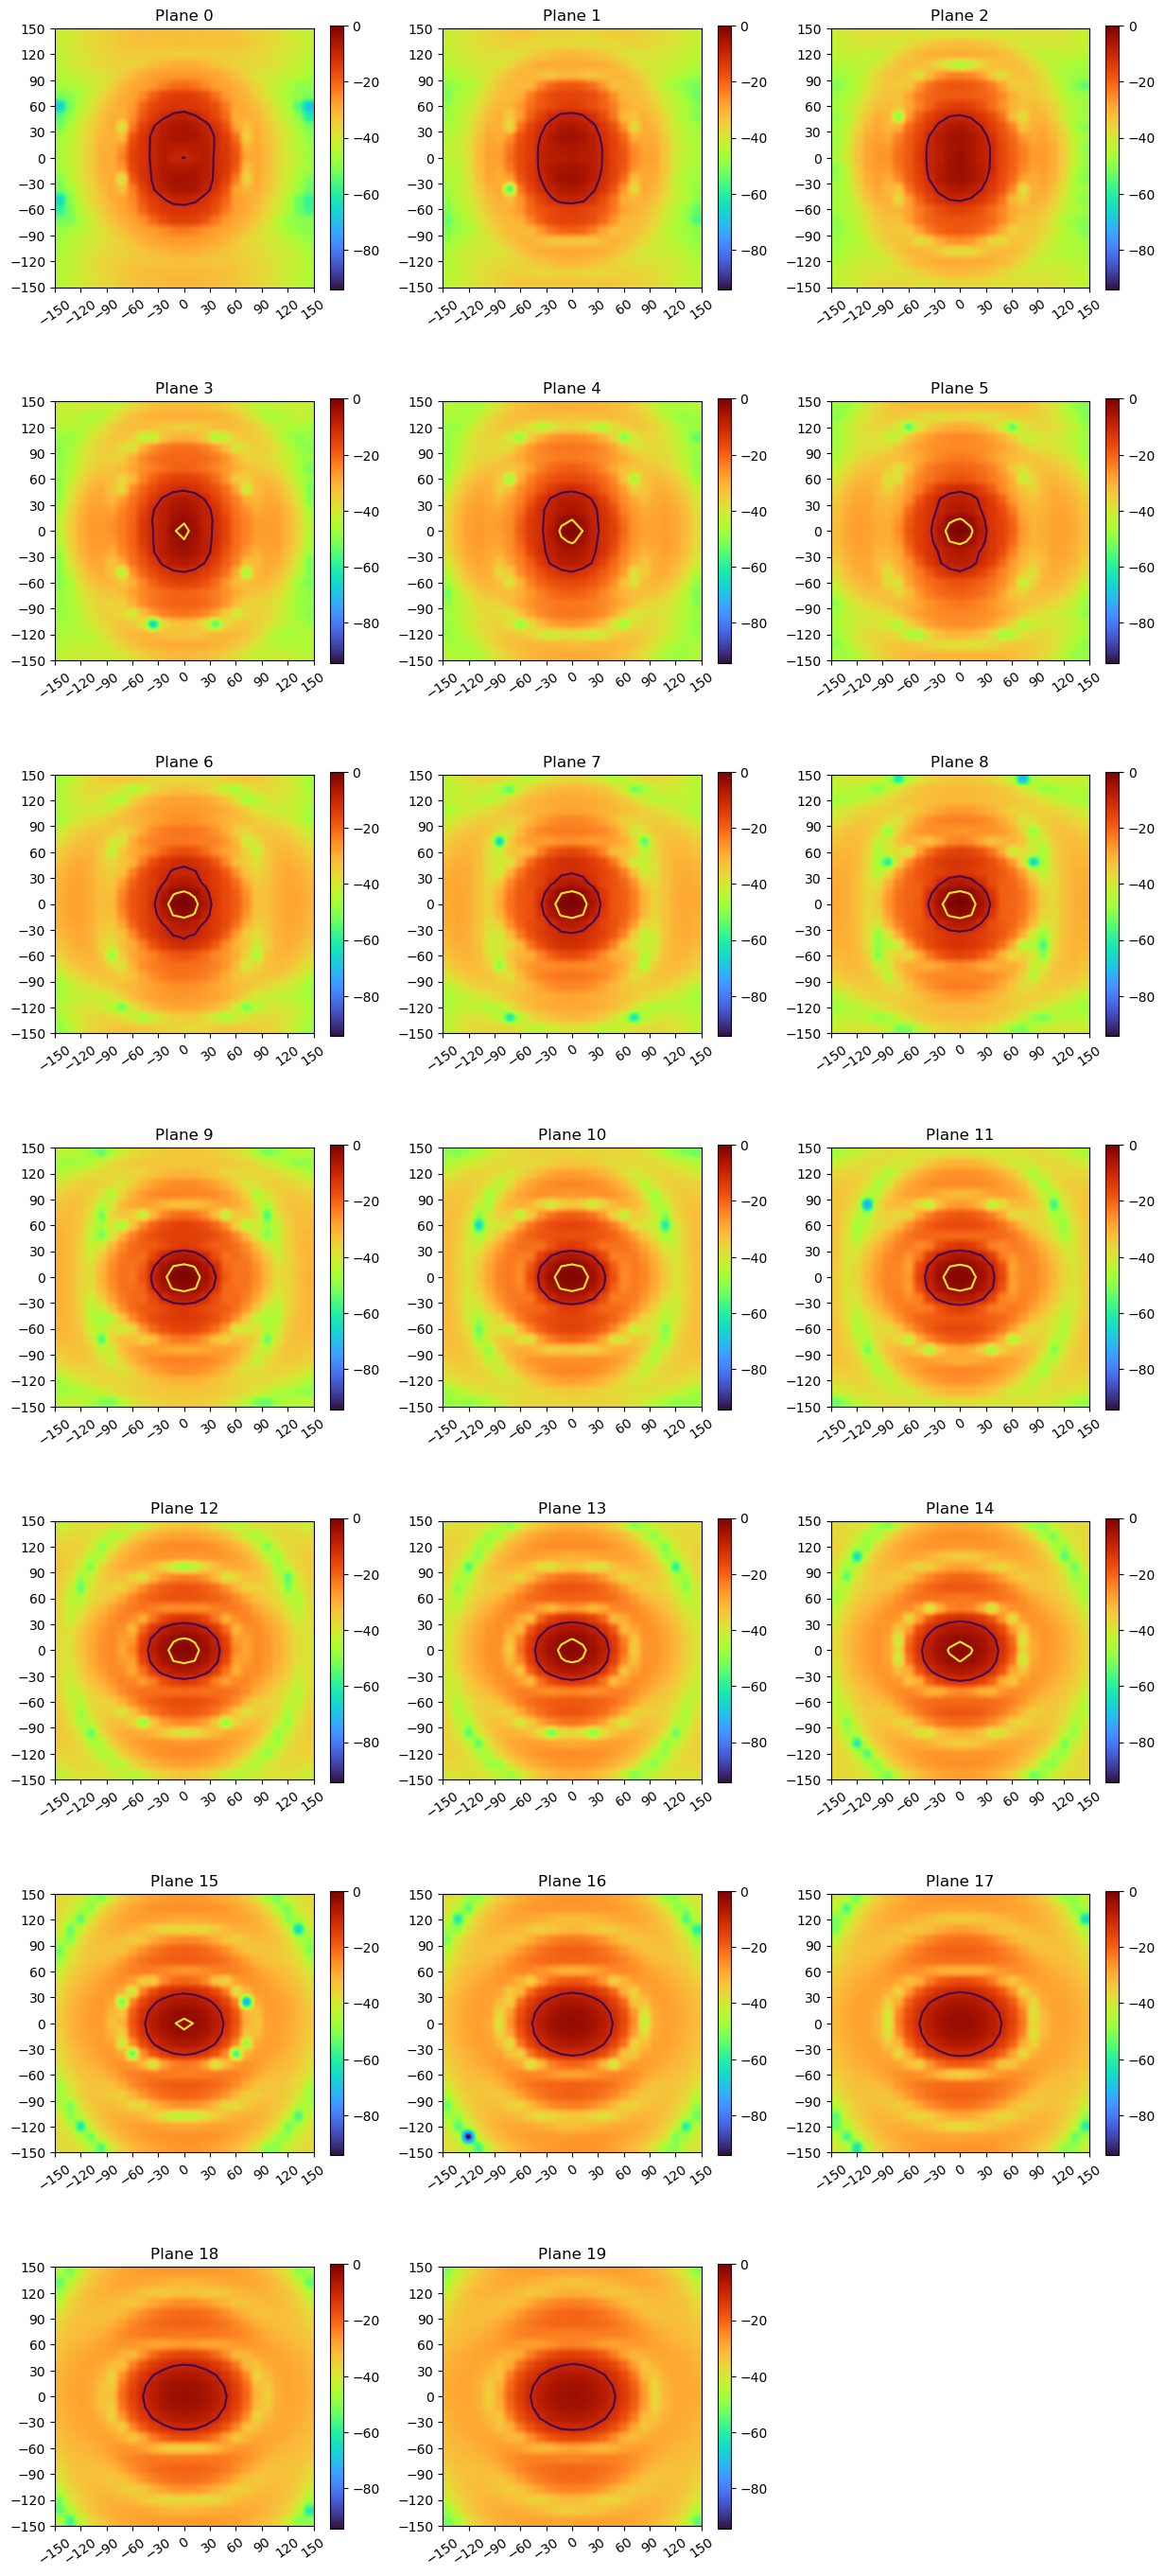

In [12]:
# Plots all planes in a single figure. Default values are: interpolationMethod='hanning'; contourLevels=[-10, -3]; 
# mag_phase='Mag Norm Planes'; and saveFig='no'. To expand of collapse the output, left click the gray rectangle at the left side.

plotMultPlanes(planesX, column=34)

E-plane beamwaist (-3 dB): 0.00 mm 
H-plane beamwaist (-3 dB): 0.00 mm


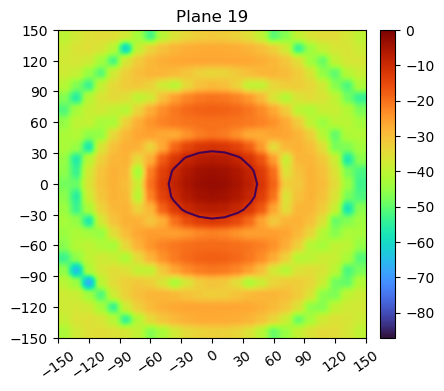

In [15]:
# Used to export a single plane (saveFig='yes') to add in the manuscript. Provides the -3 dB beamwaist of the XY plane.

plotSinglePlane(planesX, plane='Plane 19', column=64, saveFig='no')

Vertical cut in -12.5 mm.
Horizontal cut in 0 mm.


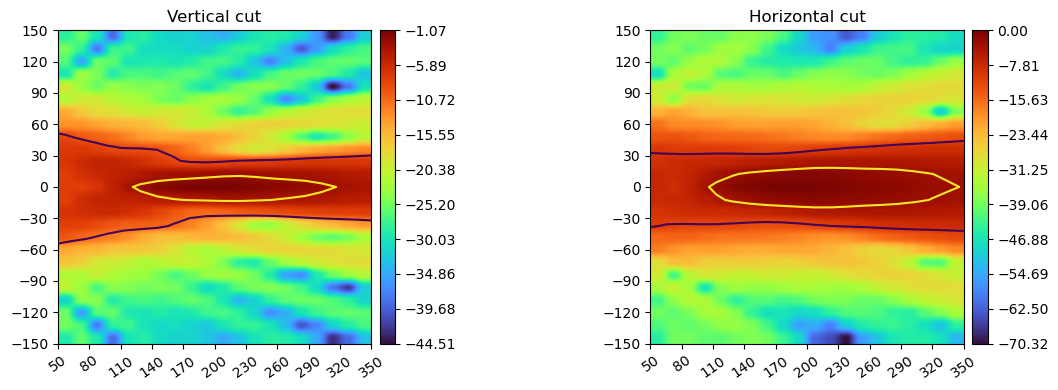

In [16]:
# Plots the vertical and horizontal cuts of all planes. It prits where the cuts were performed. It is possible to choose
# a different position to cut the graphs. In this case, the instance 'cut' must have the correct value. Otherwiase, it returns
# a list of the correct values to cut. The planes are cutted in the same frequency that all planes were plotted using plotMultPlanes.

plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
cutPlane(planesX, cut=-12.5, orientation='vertical', saveFig='no')
plt.subplot(1, 2, 2)
cutPlane(planesX, orientation='horizontal', saveFig='no')
plt.tight_layout()

Horizontal cut in 0 mm.


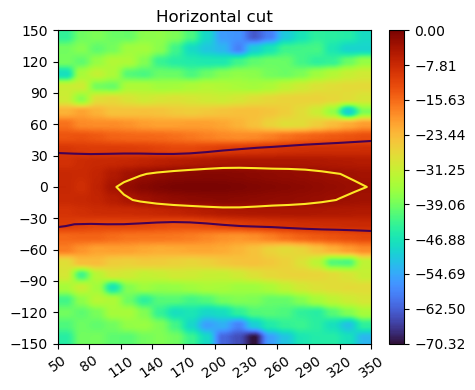

In [17]:
# Used to export a single cutted plane (saveFig='yes') to add in the manuscript. Orientation must be
# 'vertical' or 'horizontal'.

plt.figure(figsize=(12,4))
cutPlane(planesX, orientation='horizontal', saveFig='no')
plt.tight_layout()

In [13]:
# Files of the measured longitudinal and transverse plans. They are comparable to the vertical and horizontal cuts.

xHScanFile = './Data/X-band/Sections/X-band Longitudinal.txt'
xVScanFile = './Data/X-band/Sections/X-band Transverse.txt'

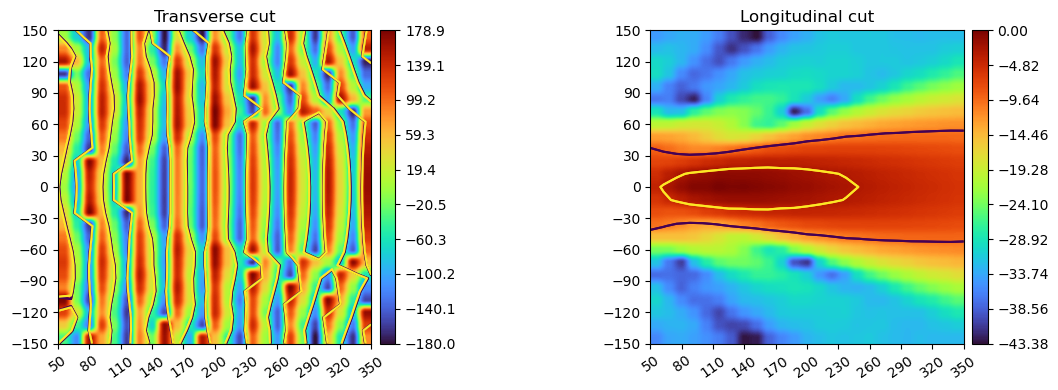

In [18]:
# Plots the transverse and longitudinal planes measured.

plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plotPlane(xVScanFile, propagation='transverse', mag_phase='Phase', column=4, saveFig='no')
plt.subplot(1, 2, 2)
plotPlane(xHScanFile, propagation='longitudinal', column=4, saveFig='no')
plt.tight_layout()

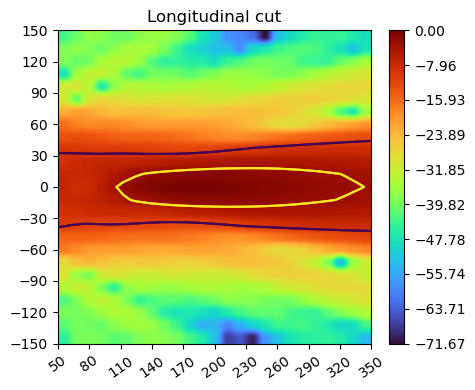

In [42]:
# Used to export the longitudinal and transverse plans (saveFig='yes') to add to the manuscript.

plt.figure(figsize=(12,4))
plotPlane(xHScanFile, propagation='longitudinal', column=64, saveFig='no')
plt.tight_layout()

# Ku-band

In [43]:
planesKu = importMultPlanes('./Data/Ku-band/Planes/')

20 planes were imported. There are 66 columns in the first plane:
Index(['Frequency', 'X', 'Y', 'Z', '12400000000.0', '12400000000.0.1',
       '12586666666.7', '12586666666.7.1', '12773333333.3', '12773333333.3.1',
       '12960000000.0', '12960000000.0.1', '13146666666.7', '13146666666.7.1',
       '13333333333.3', '13333333333.3.1', '13520000000.0', '13520000000.0.1',
       '13706666666.7', '13706666666.7.1', '13893333333.3', '13893333333.3.1',
       '14080000000.0', '14080000000.0.1', '14266666666.7', '14266666666.7.1',
       '14453333333.3', '14453333333.3.1', '14640000000.0', '14640000000.0.1',
       '14826666666.7', '14826666666.7.1', '15013333333.3', '15013333333.3.1',
       '15200000000.0', '15200000000.0.1', '15386666666.7', '15386666666.7.1',
       '15573333333.3', '15573333333.3.1', '15760000000.0', '15760000000.0.1',
       '15946666666.7', '15946666666.7.1', '16133333333.3', '16133333333.3.1',
       '16320000000.0', '16320000000.0.1', '16506666666.7', '16506666666.

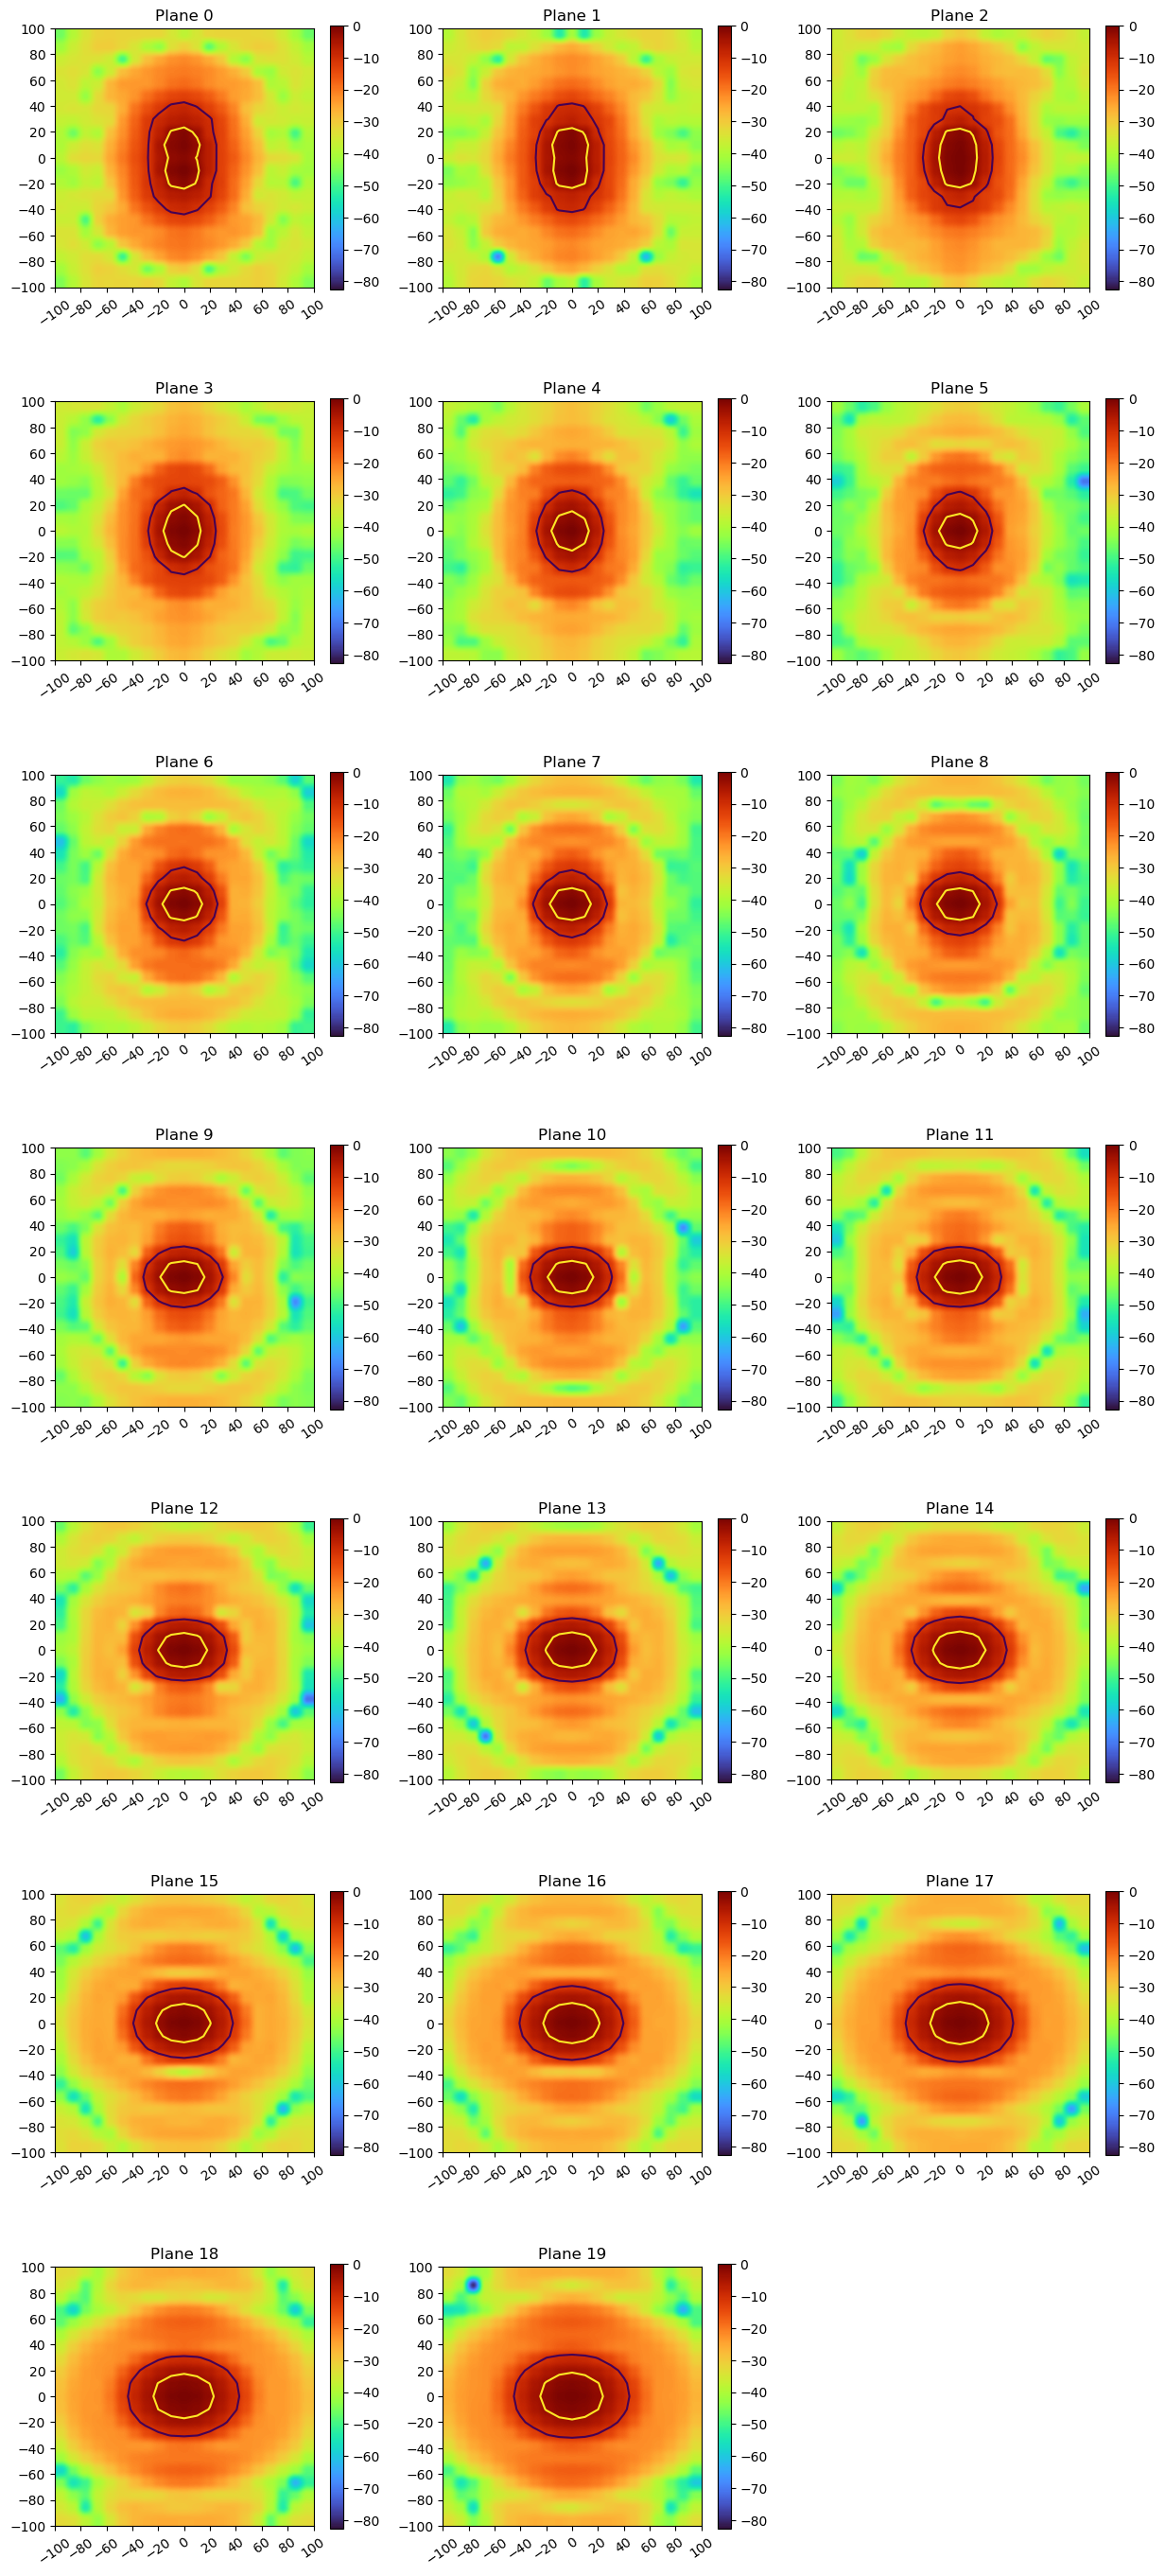

In [44]:
plotMultPlanes(planesKu, column=34, saveFig='no', mag_phase='Mag Norm')

Vertical cut in 0 mm.
Horizontal cut in 0 mm.


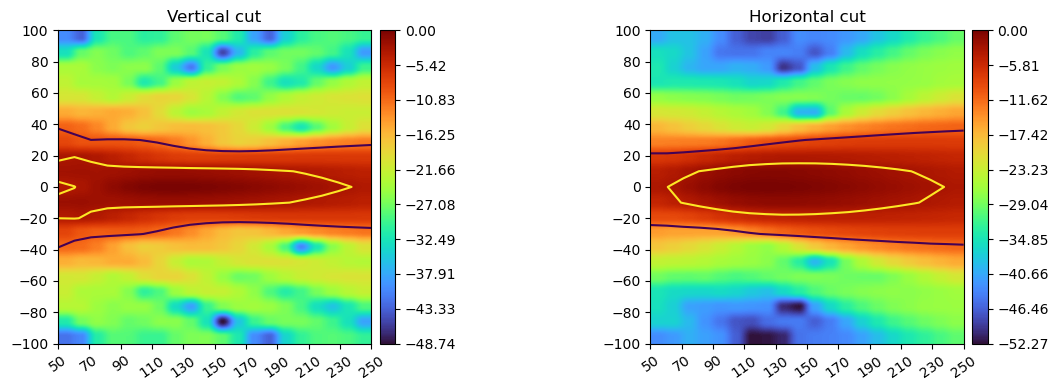

In [45]:
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
cutPlane(planesKu, orientation='vertical', saveFig='no')
plt.subplot(1, 2, 2)
cutPlane(planesKu, orientation='horizontal', saveFig='no')
plt.tight_layout()

In [46]:
kuHScanFile = './Data/Ku-band/Sections/Ku-band Longitudinal.txt'
kuVScanFile = './Data/Ku-band/Sections/Ku-band Transverse.txt'

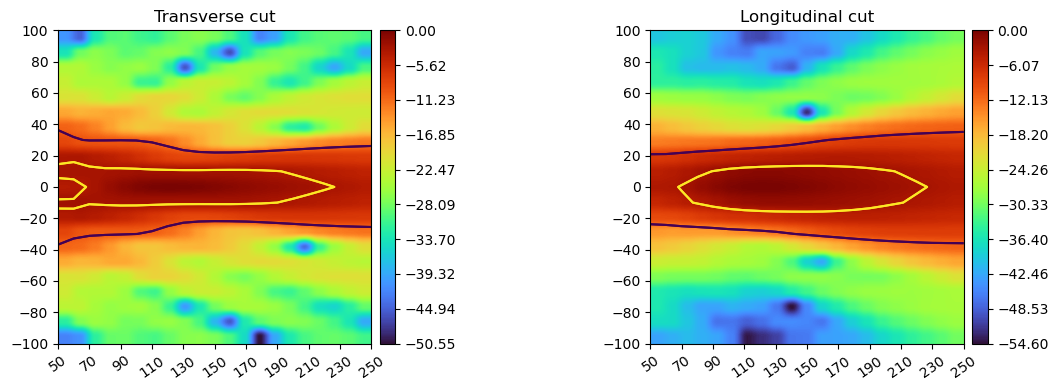

In [47]:
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plotPlane(kuVScanFile, propagation='transverse', column=34, saveFig='no')
plt.subplot(1, 2, 2)
plotPlane(kuHScanFile, propagation='longitudinal', column=34, saveFig='no')
plt.tight_layout()

# K-band

In [48]:
planesK = importMultPlanes('./Data/K-band/Planes/')

20 planes were imported. There are 66 columns in the first plane:
Index(['Frequency', 'X', 'Y', 'Z', '18000000000.0', '18000000000.0.1',
       '18283333333.3', '18283333333.3.1', '18566666666.7', '18566666666.7.1',
       '18850000000.0', '18850000000.0.1', '19133333333.3', '19133333333.3.1',
       '19416666666.7', '19416666666.7.1', '19700000000.0', '19700000000.0.1',
       '19983333333.3', '19983333333.3.1', '20266666666.7', '20266666666.7.1',
       '20550000000.0', '20550000000.0.1', '20833333333.3', '20833333333.3.1',
       '21116666666.7', '21116666666.7.1', '21400000000.0', '21400000000.0.1',
       '21683333333.3', '21683333333.3.1', '21966666666.7', '21966666666.7.1',
       '22250000000.0', '22250000000.0.1', '22533333333.3', '22533333333.3.1',
       '22816666666.7', '22816666666.7.1', '23100000000.0', '23100000000.0.1',
       '23383333333.3', '23383333333.3.1', '23666666666.7', '23666666666.7.1',
       '23950000000.0', '23950000000.0.1', '24233333333.3', '24233333333.

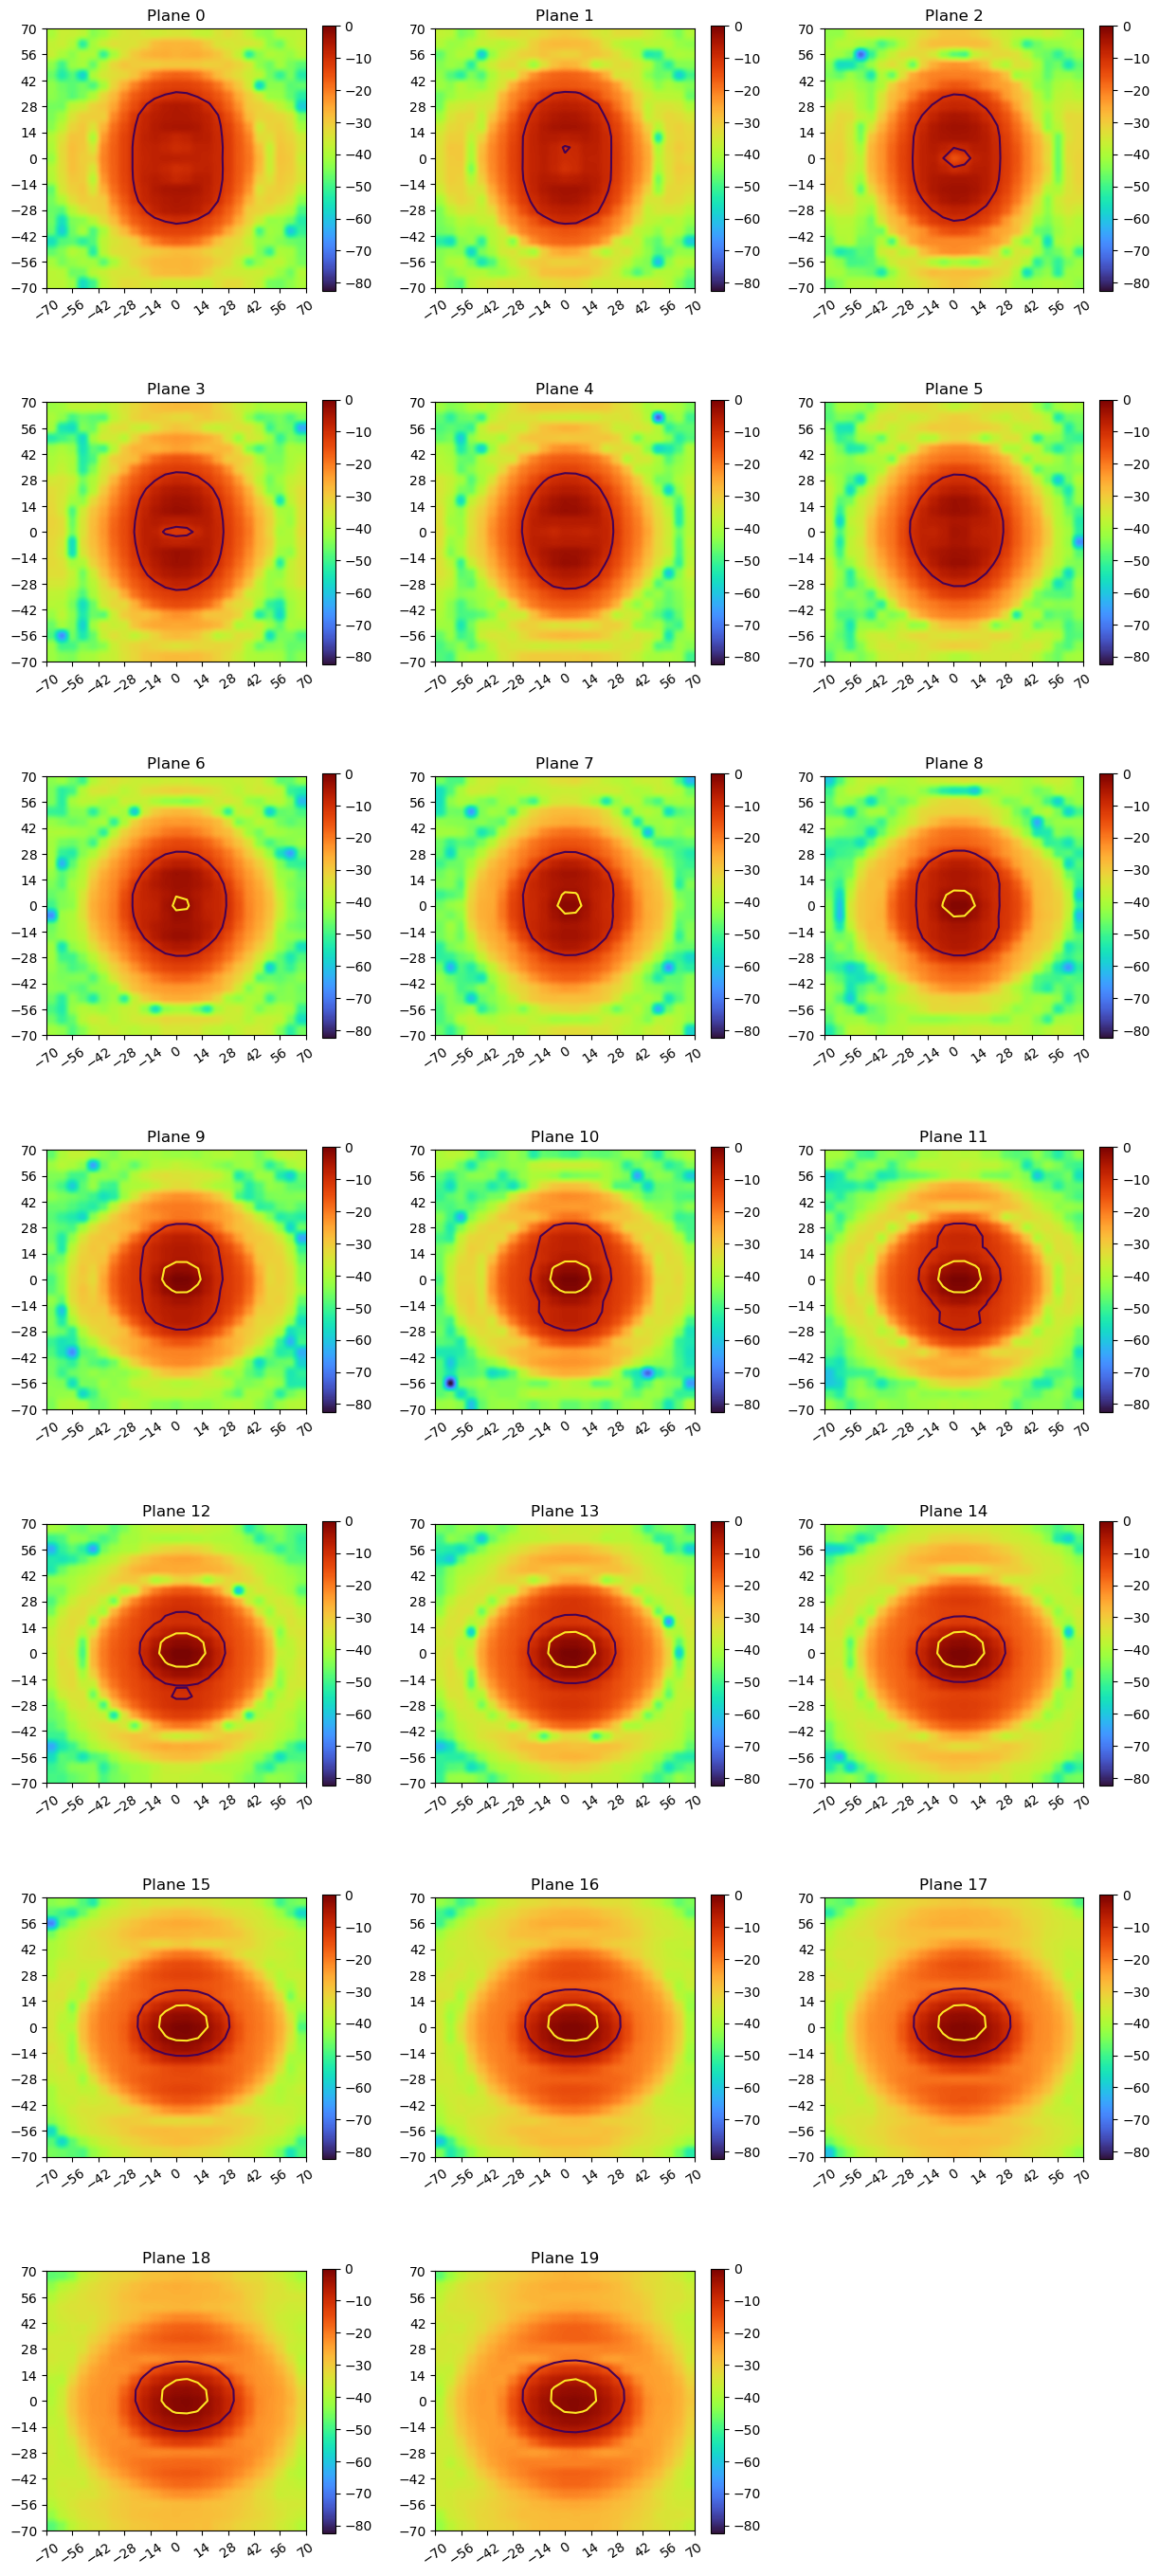

In [49]:
plotMultPlanes(planesK, column=64, saveFig='no')

Vertical cut in 0 mm.
Horizontal cut in 0 mm.


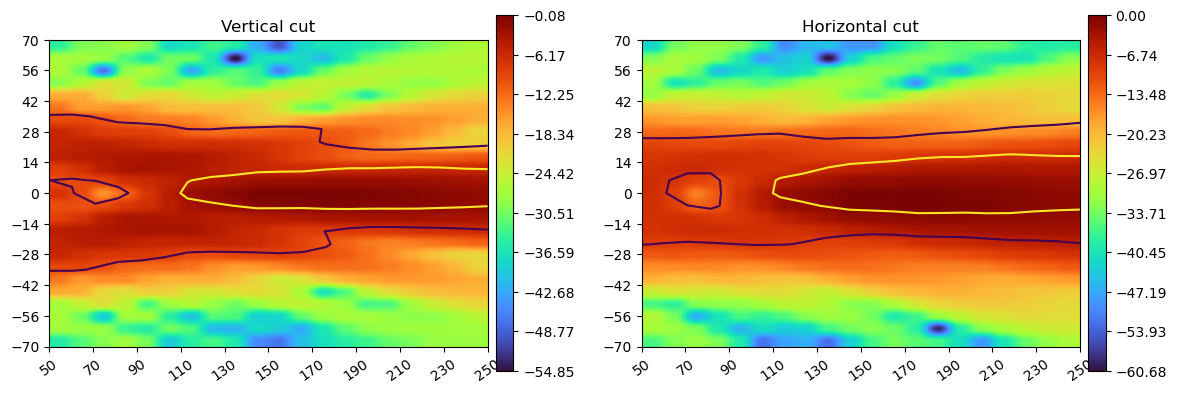

In [50]:
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
cutPlane(planesK, orientation='vertical', saveFig='no')
plt.subplot(1, 2, 2)
cutPlane(planesK, orientation='horizontal', saveFig='no')
plt.tight_layout()

In [51]:
kHScanFile = './Data/K-band/Sections/K-band Longitudinal.txt'
kVScanFile = './Data/K-band/Sections/K-band Transverse.txt'

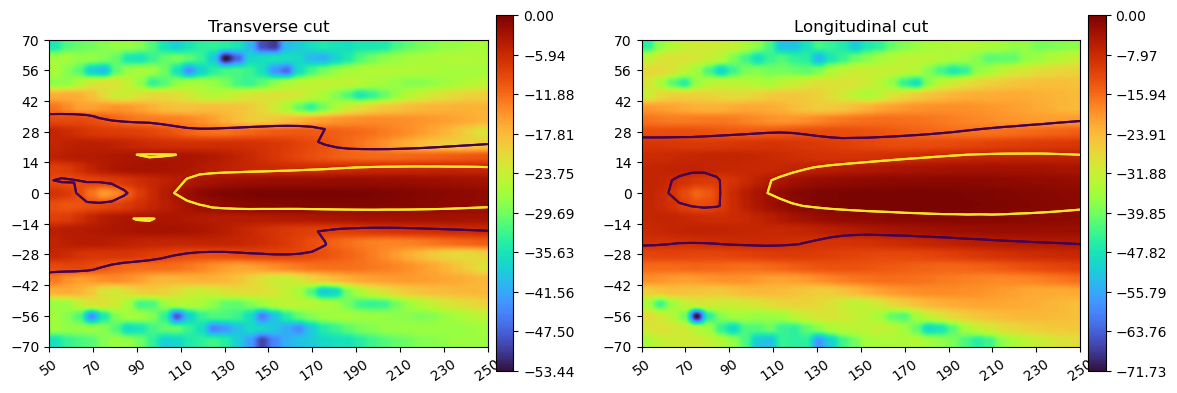

In [52]:
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plotPlane(kVScanFile, propagation='transverse', column=64, saveFig='no')
plt.subplot(1, 2, 2)
plotPlane(kHScanFile, propagation='longitudinal', column=64, saveFig='no')
plt.tight_layout()

# Ka-band

In [53]:
planesKa = importMultPlanes('./Data/Ka-band/Planes/')

20 planes were imported. There are 66 columns in the first plane:
Index(['Frequency', 'X', 'Y', 'Z', '26500000000.0', '26500000000.0.1',
       '26950000000.0', '26950000000.0.1', '27400000000.0', '27400000000.0.1',
       '27850000000.0', '27850000000.0.1', '28300000000.0', '28300000000.0.1',
       '28750000000.0', '28750000000.0.1', '29200000000.0', '29200000000.0.1',
       '29650000000.0', '29650000000.0.1', '30100000000.0', '30100000000.0.1',
       '30550000000.0', '30550000000.0.1', '31000000000.0', '31000000000.0.1',
       '31450000000.0', '31450000000.0.1', '31900000000.0', '31900000000.0.1',
       '32350000000.0', '32350000000.0.1', '32800000000.0', '32800000000.0.1',
       '33250000000.0', '33250000000.0.1', '33700000000.0', '33700000000.0.1',
       '34150000000.0', '34150000000.0.1', '34600000000.0', '34600000000.0.1',
       '35050000000.0', '35050000000.0.1', '35500000000.0', '35500000000.0.1',
       '35950000000.0', '35950000000.0.1', '36400000000.0', '36400000000.

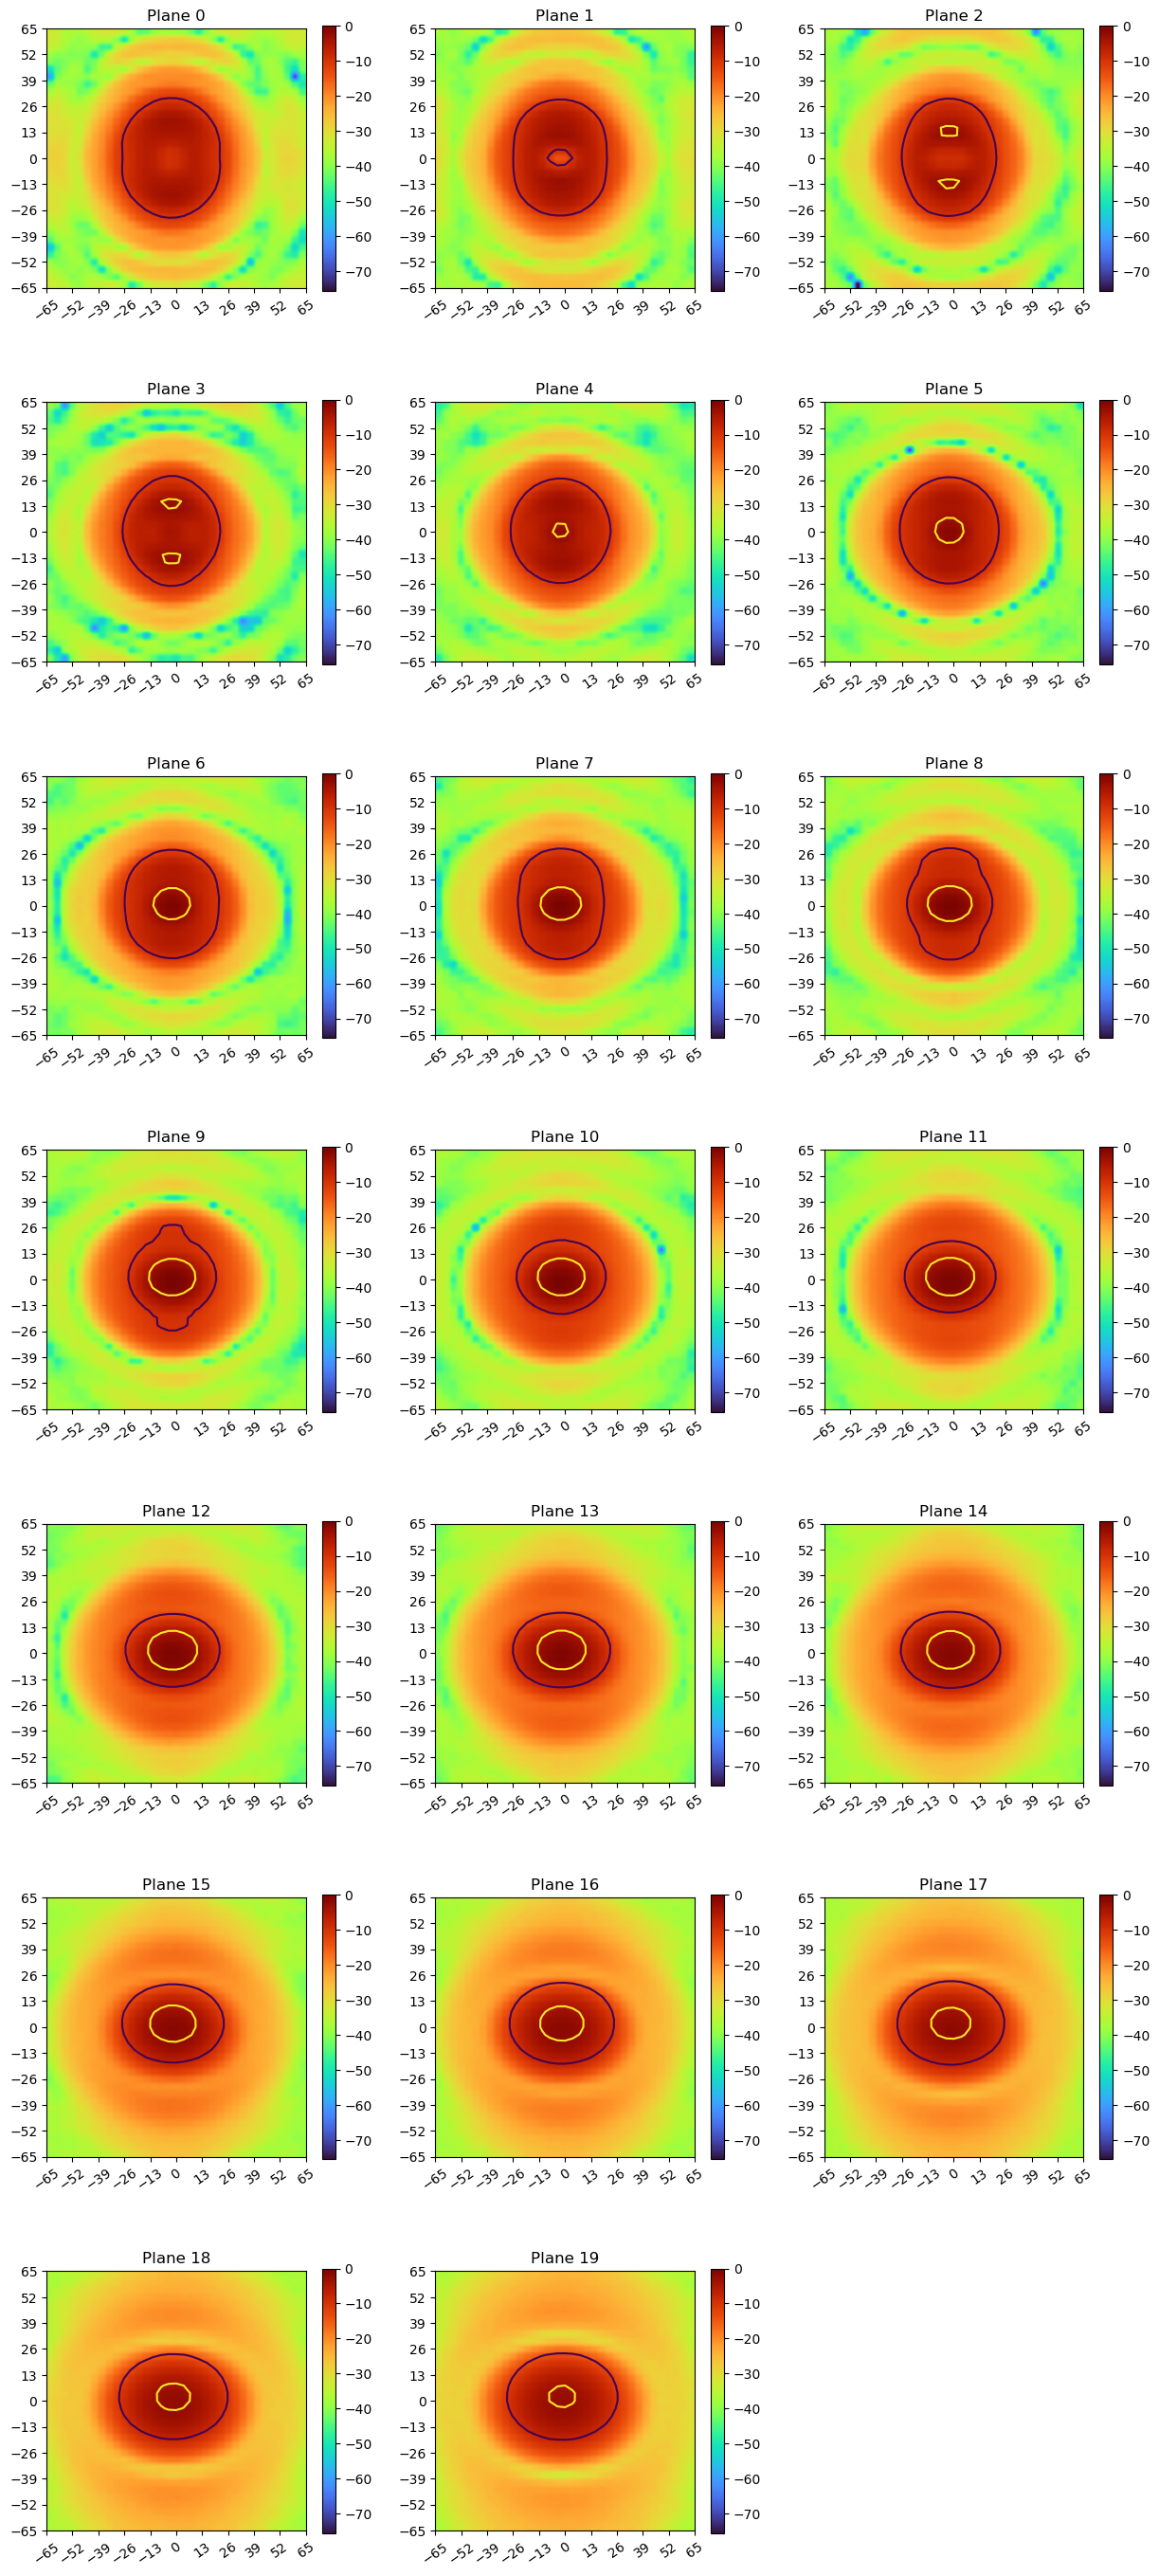

In [54]:
plotMultPlanes(planesKa, column=4, saveFig='no')

Vertical cut in 0 mm.
Horizontal cut in 0 mm.


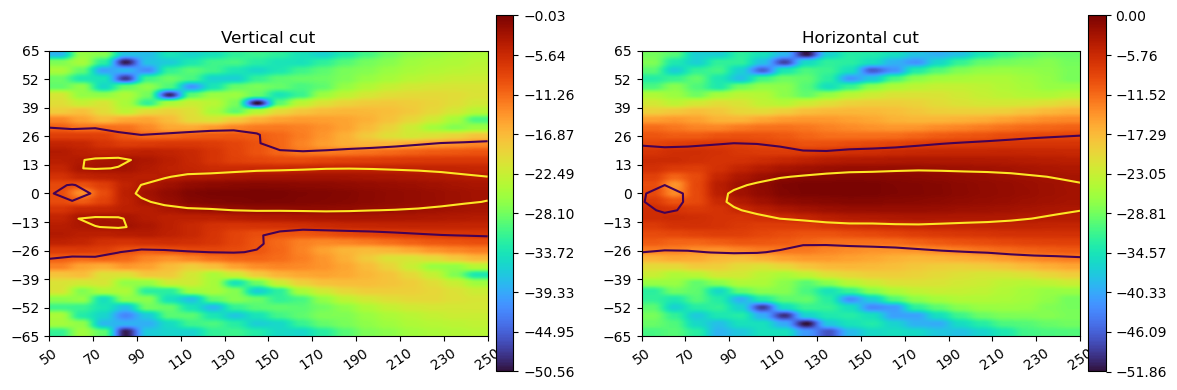

In [55]:
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
cutPlane(planesKa, orientation='vertical', saveFig='no')
plt.subplot(1, 2, 2)
cutPlane(planesKa, orientation='horizontal', saveFig='no')
plt.tight_layout()

In [56]:
kaHScanFile = './Data/Ka-band/Sections/Ka-band Longitudinal.txt'
kaVScanFile = './Data/Ka-band/Sections/Ka-band Transverse.txt'

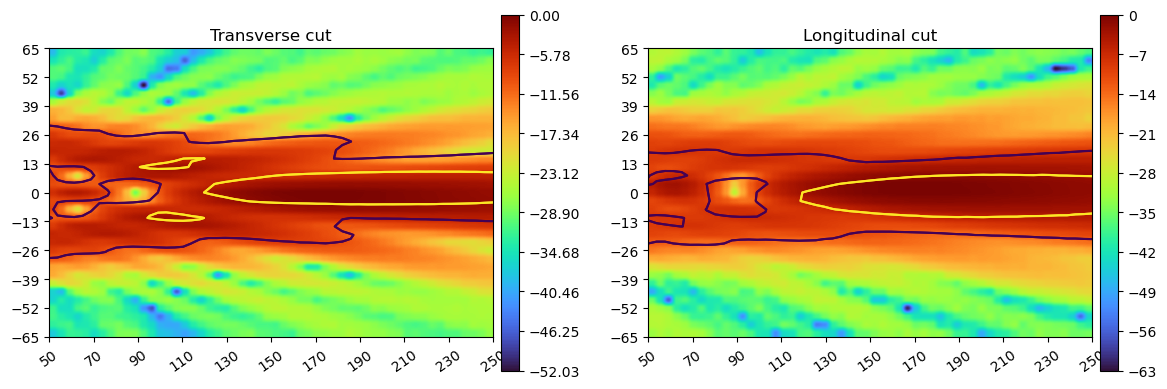

In [57]:
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plotPlane(kaVScanFile, propagation='transverse', column=64, saveFig='no')
plt.subplot(1, 2, 2)
plotPlane(kaHScanFile, propagation='longitudinal', column=64, saveFig='no')
plt.tight_layout()